In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/landcoverai/val.txt
/kaggle/input/landcoverai/test.txt
/kaggle/input/landcoverai/train.txt
/kaggle/input/landcoverai/split.py
/kaggle/input/landcoverai/images/M-34-77-B-c-2-3.tif
/kaggle/input/landcoverai/images/N-33-139-C-d-2-2.tif
/kaggle/input/landcoverai/images/M-34-51-C-d-4-1.tif
/kaggle/input/landcoverai/images/N-34-97-C-b-1-2.tif
/kaggle/input/landcoverai/images/M-34-65-D-a-4-4.tif
/kaggle/input/landcoverai/images/N-33-130-A-d-3-3.tif
/kaggle/input/landcoverai/images/M-34-65-D-c-4-2.tif
/kaggle/input/landcoverai/images/N-33-130-A-d-4-4.tif
/kaggle/input/landcoverai/images/N-34-77-A-b-1-4.tif
/kaggle/input/landcoverai/images/N-34-106-A-c-1-3.tif
/kaggle/input/landcoverai/images/M-34-68-B-a-1-3.tif
/kaggle/input/landcoverai/images/M-34-32-B-a-4-3.tif
/kaggle/input/landcoverai/images/N-33-60-D-c-4-2.tif
/kaggle/input/landcoverai/images/M-34-55-B-b-4-1.tif
/kaggle/input/landcoverai/images/M-33-7-A-d-2-3.tif
/kaggle/input/landcoverai/images/N-33-96-D-d-1-1.tif
/kaggle/i

# NOTE:
**In the Visualisation code we are using imshow() for both the images and the masks without specifying a colormap (cmap). This works fine for the images, as they are typically RGB or multi-channel, so they are visualized naturally without a colormap. the segmentation masks, which are likely single-channel (grayscale), imshow() might display the masks in a default colormap (often a colored heatmap or grayscale). so one mask prediction may show one class as one color and some other prediction may show same class some different color. Although the segmentation of classes is correct and the metric scores too**

# Importing the Libraries

In [ ]:
import torch
from torch import nn
import torchvision

In [3]:

import glob
import os
import cv2

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import transforms
from pathlib import Path
import random
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import torch.optim as optim
from tqdm.notebook import tqdm
from tqdm import tqdm

import matplotlib.colors
import seaborn as sns

In [4]:
from torchvision import models

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Splitting the Image Mask tiles in size of 512x512 

In [6]:
IMGS_DIR = "/kaggle/input/landcoverai/images"  #Path to Directory containing Images tiles  
MASKS_DIR = "/kaggle/input/landcoverai/masks"   #Path to Directory contining Masks tiles
OUTPUT_DIR_IMAGE = "/kaggle/working/output/images" #Path to #directory where you want to store the splitted images
OUTPUT_DIR_MASK = "/kaggle/working/output/masks" #Path to #directory where you want to store the splitted masks
TARGET_SIZE = 512

# Create output directories if they don't exist
os.makedirs(OUTPUT_DIR_IMAGE, exist_ok=True)
os.makedirs(OUTPUT_DIR_MASK, exist_ok=True)

# Get list of image and mask paths
img_paths = glob.glob(os.path.join(IMGS_DIR, "*.tif"))
mask_paths = glob.glob(os.path.join(MASKS_DIR, "*.tif"))

# Sort paths to ensure consistent ordering
img_paths.sort()
mask_paths.sort()

for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
    # Extract base filename without extension
    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    mask_filename = os.path.splitext(os.path.basename(mask_path))[0]
    
    # Read images and masks
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)

    # Check if filenames and shapes match
    assert img_filename == mask_filename and img.shape[:2] == mask.shape[:2]

    k = 0
    for y in range(0, img.shape[0], TARGET_SIZE):
        for x in range(0, img.shape[1], TARGET_SIZE):
            img_tile = img[y:y + TARGET_SIZE, x:x + TARGET_SIZE]
            mask_tile = mask[y:y + TARGET_SIZE, x:x + TARGET_SIZE]

            if img_tile.shape[0] == TARGET_SIZE and img_tile.shape[1] == TARGET_SIZE:
                # Generate new filenames with unique identifiers
                out_img_filename = "{}_tile_{}.jpg".format(img_filename, k)
                out_mask_filename = "{}_tile_{}_m.png".format(mask_filename, k)
                
                # Save the image and mask tiles
                out_img_path = os.path.join(OUTPUT_DIR_IMAGE, out_img_filename)
                out_mask_path = os.path.join(OUTPUT_DIR_MASK, out_mask_filename)
                
                cv2.imwrite(out_img_path, img_tile)
                cv2.imwrite(out_mask_path, mask_tile)

                k += 1

    print(f"Processed {img_filename} {i + 1}/{len(img_paths)}")


Processed M-33-20-D-c-4-2 1/41
Processed M-33-20-D-d-3-3 2/41
Processed M-33-32-B-b-4-4 3/41
Processed M-33-48-A-c-4-4 4/41
Processed M-33-7-A-d-2-3 5/41
Processed M-33-7-A-d-3-2 6/41
Processed M-34-32-B-a-4-3 7/41
Processed M-34-32-B-b-1-3 8/41
Processed M-34-5-D-d-4-2 9/41
Processed M-34-51-C-b-2-1 10/41
Processed M-34-51-C-d-4-1 11/41
Processed M-34-55-B-b-4-1 12/41
Processed M-34-56-A-b-1-4 13/41
Processed M-34-6-A-d-2-2 14/41
Processed M-34-65-D-a-4-4 15/41
Processed M-34-65-D-c-4-2 16/41
Processed M-34-65-D-d-4-1 17/41
Processed M-34-68-B-a-1-3 18/41
Processed M-34-77-B-c-2-3 19/41
Processed N-33-104-A-c-1-1 20/41
Processed N-33-119-C-c-3-3 21/41
Processed N-33-130-A-d-3-3 22/41
Processed N-33-130-A-d-4-4 23/41
Processed N-33-139-C-d-2-2 24/41
Processed N-33-139-C-d-2-4 25/41
Processed N-33-139-D-c-1-3 26/41
Processed N-33-60-D-c-4-2 27/41
Processed N-33-60-D-d-1-2 28/41
Processed N-33-96-D-d-1-1 29/41
Processed N-34-106-A-b-3-4 30/41
Processed N-34-106-A-c-1-3 31/41
Processed N-

# Defining the Augmentations

In [7]:
import albumentations as A

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
# Configuring the set of transformations
train_transforms = A.Compose([
    A.OneOf([
        A.HueSaturationValue(40,40,30,p=1),
        A.RandomBrightnessContrast(p=1,brightness_limit = 0.2,
                                  contrast_limit = 0.5)], p = 0.5),
    A.OneOf([
        A.RandomRotate90(p=1),
        A.HorizontalFlip(p=1),
        A.RandomSizedCrop(min_max_height=(248,512),height=512,width=512, p =1)
    ], p = 0.5)])

 

# Custom Dataset class

In [9]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        
        self.transform = transforms  # Apply transforms only for training
        self.image = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        self.image_paths = []
        self.masks_paths = []

        for idx in range(len(self.image)):
            self.image_paths.append(os.path.join(self.image_dir, self.image[idx]))

        for idx in range(len(self.masks)):
            self.masks_paths.append(os.path.join(self.mask_dir, self.image[idx].replace(".jpg", "_m.png")))

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.masks_paths[idx]

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        image = np.array(image)
        mask = np.array(mask)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = np.transpose(transformed["image"], (2, 0, 1))
            mask = transformed["mask"]
        else:
            # If no transform, convert directly to CHW
            image = np.transpose(image, (2, 0, 1))

        # Convert NumPy array to PyTorch tensor
        image = torch.from_numpy(image)  # Change dimension order from HWC to CHW
        mask = torch.from_numpy(mask).long()

        return image, mask


# Creating the dataset and dataloaders

In [10]:

dataset = SegmentationDataset(image_dir='/kaggle/working/output/images', mask_dir='/kaggle/working/output/masks', transforms=None)

In [11]:
from torch.utils.data import Dataset, DataLoader, Subset

In [12]:
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)
indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
train_subset = Subset(dataset, train_indices)

test_subset = Subset(dataset, test_indices)

In [13]:
print(len(train_subset))
print(len(test_subset))


8539
2135


In [14]:
train_subset.dataset.transforms = train_transforms  # Apply augmentation to training set

test_subset.dataset.transforms = None # No augmentation for test

In [15]:
train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True)

test_dataloader = DataLoader(test_subset, batch_size=8, shuffle=False)

In [16]:
print(len(train_subset))
print(len(test_subset))


8539
2135


# Example visualisation of Dataset

Batch 0


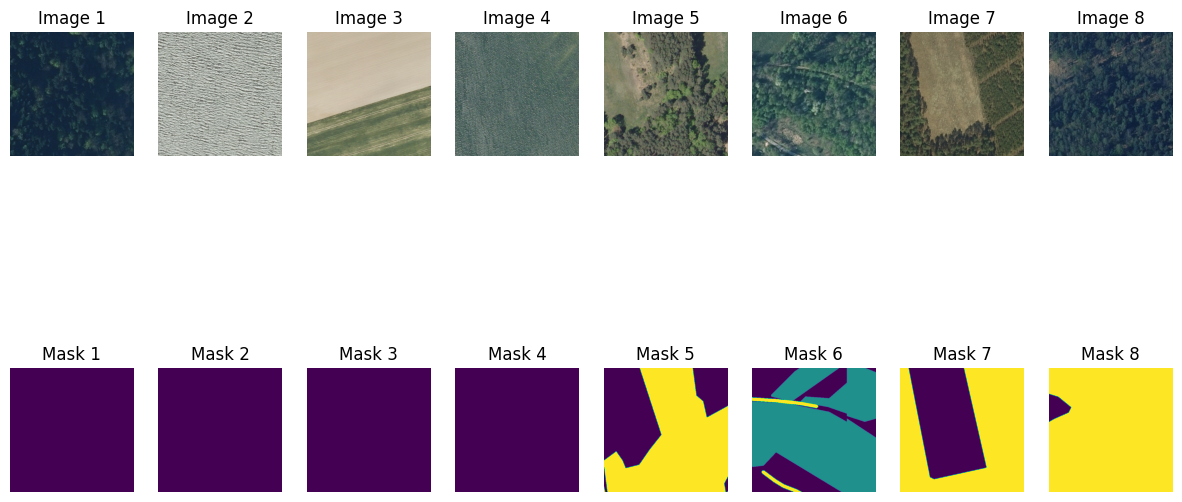

In [17]:
for batch_idx, (images, masks) in enumerate(train_dataloader):
    print(f"Batch {batch_idx}")
    
    fig, axes = plt.subplots(2, images.size(0), figsize=(15, 8))
    for i in range(images.size(0)):
        ax = axes[0, i]
        img = images[i].permute(1, 2, 0).numpy()  
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Image {i+1}')
        
        ax = axes[1, i]
        msk = masks[i].squeeze().numpy()  
        ax.imshow(msk)
        ax.axis('off')
        ax.set_title(f'Mask {i+1}')
    
    plt.show()
    break

# Model Architecture

In [18]:
class attention_block(nn.Module):
    def __init__(self,g,x,i):
        super(attention_block,self).__init__()
        self.wg=nn.Sequential(nn.Conv2d(g,i,kernel_size=1,stride=1,padding=0),
                              nn.BatchNorm2d(i)
                             )
        
        self.wx=nn.Sequential(nn.Conv2d(x,i,kernel_size=1,stride=1,padding=0),
                              nn.BatchNorm2d(i)
                             )
        self.psi=nn.Sequential(
            nn.Conv2d(i,1,kernel_size=1,stride=1,padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()      )
    
    def forward(self,g,x):
        g1=self.wg(g)
        x1=self.wx(x)
        if g1.size() != x1.size():
            g1 = F.interpolate(g1, size=x1.size()[2:], mode='bilinear', align_corners=True)
        psi=nn.ReLU()(g1+x1)
        psi=self.psi(psi)    
        return psi*x
            
            
class conv(nn.Module):  #used for Convolution
    def __init__(self,in_channels,out_channels):
            
        super(conv,self).__init__()
        self.conv2d=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_channels),    
        nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_channels),    
        nn.ReLU() 
        )
    def forward(self,x):
        
        x=self.conv2d(x)
        return x    

In [19]:
class upconv(nn.Module):    #Used for upsampling
    def __init__(self,in_channels,out_channels):
        super(upconv,self).__init__()
        self.up=nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels)  
        )
        
    def forward(self,x):
        x=self.up(x)
        return x

In [20]:
import torch.nn.functional as F

class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, pool_sizes=(1, 2, 3, 6)):
        super(PyramidPoolingModule, self).__init__()
        self.pool1 = nn.AdaptiveAvgPool2d(pool_sizes[0])
        self.pool2 = nn.AdaptiveAvgPool2d(pool_sizes[1])
        self.pool3 = nn.AdaptiveAvgPool2d(pool_sizes[2])
        self.pool4 = nn.AdaptiveAvgPool2d(pool_sizes[3])
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False),
            nn.BatchNorm2d(in_channels // 4))
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False),
                                   nn.BatchNorm2d(in_channels // 4))
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False),
                                   nn.BatchNorm2d(in_channels // 4))
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False),
                                   nn.BatchNorm2d(in_channels // 4))
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        h, w = x.size(2), x.size(3)
        # Pool and then upsample each feature map
        feat1 = F.interpolate(self.relu(self.conv1(self.pool1(x))), size=(h, w), mode='bilinear', align_corners=True)
        feat2 = F.interpolate(self.relu(self.conv2(self.pool2(x))), size=(h, w), mode='bilinear', align_corners=True)
        feat3 = F.interpolate(self.relu(self.conv3(self.pool3(x))), size=(h, w), mode='bilinear', align_corners=True)
        feat4 = F.interpolate(self.relu(self.conv4(self.pool4(x))), size=(h, w), mode='bilinear', align_corners=True)
        # Concatenate along the channel dimension
        out = torch.cat([x, feat1, feat2, feat3, feat4], dim=1)
        return out

In [21]:
class MODEL(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MODEL, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.resnet = models.resnet50(weights="IMAGENET1K_V1")

        # Encoder
        self.e1 = nn.Sequential(*list(self.resnet.children())[:4])  # output: 64
        self.e2 = self.resnet.layer1  # output: 256
        self.e3 = self.resnet.layer2  # output: 512
        self.e4 = self.resnet.layer3  # output: 1024

        # Pyramid Pooling Module
        self.ppm = PyramidPoolingModule(in_channels=1024)

        # Decoder
        self.d1 = upconv(in_channels=2048, out_channels=512)  # adjusted for ppm output
        self.att1 = attention_block(g=512, x=512, i=256)
        self.up_conv1 = conv(in_channels=1024, out_channels=512)

        self.d2 = upconv(in_channels=512, out_channels=256)
        self.att2 = attention_block(g=256, x=256, i=128)
        self.up_conv2 = conv(in_channels=512, out_channels=256)

        self.d4 = upconv(in_channels=256, out_channels=64)
        self.att4 = attention_block(g=64, x=64, i=32)
        self.up_conv4 = conv(in_channels=128, out_channels=64)
        self.up_conv5=upconv(in_channels=64, out_channels=64)
        # Final Convolution
        self.conv1x1 = nn.Conv2d(64, out_channels, kernel_size=1)
        self.max=nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        # Encoding
        x1 = self.e1(x)  # output: 64
        x2 = self.e2(x1)  # output: 256
        x3 = self.e3(x2)  # output: 512
        x4 = self.e4(x3)  # output: 1024

        # Apply Pyramid Pooling Module to x4
        x4 = self.ppm(x4)  # output: 2048

        # Decoding
        y1 = self.d1(x4)
        x3 = self.att1(y1, x3)
        y1 = torch.cat((x3, y1), dim=1)
        y1 = self.up_conv1(y1)

        y2 = self.d2(y1)
        x2 = self.att2(y2, x2)
        y2 = torch.cat((x2, y2), dim=1)
        y2 = self.up_conv2(y2)

        y4 = self.d4(y2)
        y4=self.max(y4)
        x1 = self.att4(y4, x1)
        y4 = torch.cat((x1, y4), dim=1)
        y4 = self.up_conv4(y4)
        y4 = self.up_conv5(y4)
        y4 = self.up_conv5(y4)
        # Final output
        y5 = self.conv1x1(y4)

        return y5

model = MODEL(3, 5)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s] 


Attention_Unet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

# Defining the Loss function and Optimizer

In [24]:
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Train Loop

In [65]:
import torch
from tqdm import tqdm

torch.manual_seed(32)
num_epochs = 1
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Training loop
    for X, Y in tqdm(train_dataloader, total=len(train_dataloader), leave=False):
        optimizer.zero_grad()
        X = X.to(device).float()
        Y = Y.to(device)
        
        # Forward pass
        outputs = model(X)
        
       
        targets = Y
        
        # Compute loss
        loss = criterion(outputs, targets)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X.size(0)
    
    epoch_loss = running_loss / len(train_dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}')
    
    # Test loop (evaluation)
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for X_test, Y_test in tqdm(test_dataloader, total=len(test_dataloader), leave=False):
            X_test = X_test.to(device).float()
            Y_test = Y_test.to(device)
            
            # Forward pass
            outputs_test = model(X_test)
            
           
            targets_test = Y_test
            train_losses.append(criterion(outputs_test, targets_test))
            # Compute loss
            test_loss += criterion(outputs_test, targets_test).item() * X_test.size(0)
            
    test_loss /= len(test_dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}')

print("Training and evaluation complete!")


Epoch [1/1], Training Loss: 0.0580


Epoch [1/1], Test Loss: 0.1756
Training and evaluation complete!


# NOTE:
**The above model wasnt trained on 1 epoch it was trained on 25 epochs intially but then few more epochs were added one by one to lower the loss in total model was trained on 30 epochs**

In [66]:
import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex

In [67]:
jaccard_metric = MulticlassJaccardIndex(num_classes=5).to(device)

# Functions to evaluate the IOU Classwise Score and Overall Mean Score

In [95]:
import numpy as np
import torch
from tqdm import tqdm  # For progress bar

def calculate_iou(mask_true, mask_pred, num_classes):
    intersection = np.histogram2d(mask_true.flatten(), mask_pred.flatten(), bins=(num_classes, num_classes), range=[[0, num_classes], [0, num_classes]])[0]
    area_true = np.histogram(mask_true, bins=num_classes, range=(0, num_classes))[0]
    area_pred = np.histogram(mask_pred, bins=num_classes, range=(0, num_classes))[0]
    area_union = area_true[:, None] + area_pred[None, :] - intersection

    relevant_classes = area_true > 0
    iou_per_class = np.divide(intersection, area_union, out=np.zeros_like(intersection, dtype=float), where=area_union!=0)
    valid_iou = np.diag(iou_per_class)

    overall_iou = np.nanmean(valid_iou[relevant_classes]) if relevant_classes.any() else 0

    return overall_iou, valid_iou, relevant_classes


def evaluate_model(test_dataloader, model, num_classes, device):
    model.eval()
    overall_iou_sum = 0
    num_samples = 0
   
    class_iou_sum = np.zeros(num_classes)  # Initialize IoU for each class
    relevant_classes_count = np.zeros(num_classes, dtype=int)
    with torch.no_grad():
        for real_X, real_Y in tqdm(test_dataloader):  
            real_X = real_X.to(device).float() 
            real_Y = real_Y.to(device)

            # Get model predictions
            predictions = model(real_X) 
            predicted_masks = torch.argmax(predictions, dim=1).cpu().numpy()  # Convert to class indices

            # Convert true masks to numpy
            true_masks = real_Y.cpu().numpy()
            
            # Calculate IoU
            overall_iou, valid_iou, relevant_classes = calculate_iou(true_masks, predicted_masks, num_classes)
            
            class_iou_sum += valid_iou
            relevant_classes_count += relevant_classes.astype(int)
            overall_iou_sum += overall_iou
            num_samples += 1
    average_iou = overall_iou_sum / num_samples if num_samples > 0 else 0
    
    # Calculate mean IoU per class
    mean_class_iou = np.divide(class_iou_sum, relevant_classes_count, out=np.zeros_like(class_iou_sum, dtype=float), where=relevant_classes_count!=0)

    print(f'Average IoU over test dataset: {average_iou:.4f}')
    print(f'Mean IoU per class: {mean_class_iou}')     


evaluate_model(test_dataloader, model, num_classes=5, device=device)



100%|██████████| 267/267 [01:42<00:00,  2.60it/s]

Average IoU over test dataset: 0.7656
Mean IoU per class: [0.91830484 0.6689446  0.88341989 0.79464136 0.53495039]


# NOTE:
**#the classwise IOU Score order is [background building woodland water roads]**

# Visualising the Results

In [ ]:
def visualize_segmentation(model, dataloader, device):
    model.eval()
    j=0
    with torch.no_grad():
        for batch in dataloader:
            images, masks = batch
            images, masks = images.to(device), masks.to(device)
            image=images.float()
            preds = model(image)
            preds = torch.argmax(preds, dim=1) 

            images_np = images.cpu().numpy().transpose(0, 2, 3, 1)  
            masks_np = masks.cpu().numpy()     
            preds_np = preds.cpu().numpy()

            batch_size = images_np.shape[0]
            
            for i in range(batch_size):
                plt.figure(figsize=(12, 6))
                
                # Input image
                plt.subplot(1, 3, 1)
                plt.imshow(images_np[i])
                plt.title("Input Image")
                
                # Ground truth mask (class index for each pixel)
                plt.subplot(1, 3, 2)
                plt.imshow(masks_np[i])
                plt.title("Ground Truth Mask")
                
                # Predicted mask (class index for each pixel)
                plt.subplot(1, 3, 3)
                plt.imshow(preds_np[i])
                plt.title("Predicted Mask")
                
                plt.show()
            if(j==10):
                break
                
            j=j+1
# Now call the function to visualize
visualize_segmentation(model, test_dataloader, device)

# Saving The Model

In [87]:
torch.save(model.state_dict(), 'model_trained_before.pth')